# **Declaration:**
The code for ***adaboost, borda voting and stacked generalization*** are picked from my submissions from the previous assignments. Author of the code is **Sarthak (me)**.

The code has been tweaked to deal with real data and to handle real classifiers.

# A composite calssifier system design: conepts and methodology

Here, we partiotion the feature space into two regions which are divided between multiple classfiers. The two preferred classifiers are the linear classifiers (Logistic regression) which is the simplest classifier model and requires least computation and a classifier which requires high computation capacity. Here we prefer knn which is a non parametric classifier.

The approach to divide the feature space is the following: We come up with two hyperplanes which divide the feature space. If both the hyperplanes agree to classify the training data in the same class then it is simply used to train the logistic regression classifier, if it falls in the critical region then it is used to train the knn classifier.

The idea here is to reduce the actual classification/prediction time and not the learning time of the classifiers.

During the prediction phase, if the data point lies in the critical phase, or if the prediction probability of the data point is less, then only it is referred to the knn classifier. Else, it is predicted by the logistic regression classifier.

**Note:** the Orginal paper uses some optimization algorithms like SWIFT algorithm to decide the two hyperplanes to identify the critical region. However, as our variation, we will two different hyperplanes identified by LDA. So the dimensions of the feature set can be anything. However, the current apporach is restricted for binary classification, just like the illustration in the original paper. the reaon is, for binary classification LDA can identify hyperplanes.....but for multi-class classification LDA Identifies axes.

BUt, if LDA works for 2-class classification, it can also be extended to multi-class classification.

## Importing Libraries

In [1]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from numpy.random import choice 
import pandas as pd
import random
import math
import time

In [2]:
np.__version__

'1.21.6'

## Loading and splitting the data (Will be used for futher Ensembles as well)

In [3]:
def prepare_data():
  data = load_iris() #load the iris data set.
  W = pd.DataFrame(data.data[50:], columns= ['feature1','feature2','feature3','feature4']) # storing the data into a data frame.
  z = pd.Series(data.target[50:]) # storing the labels in a series
  z = z-1
  X, X_test, y, y_test = train_test_split(W,z,test_size=0.1,shuffle = True) # splitting the data

  # Resetting the index for ease
  X=X.reset_index(drop = True) 
  X_test= X_test.reset_index(drop = True)
  y = y.reset_index(drop = True)
  y_test = y_test.reset_index(drop =True)


  return W,z,X,y,X_test,y_test

In [4]:
class CompositeClassifierDesign:
  def __init__(self,simple_classifier,critical_classifier):
    self.lda1 =LinearDiscriminantAnalysis(solver = 'svd') # LDA with svd solver to get hyper plane 1 
    self.lda2 =LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage ='auto') #LDA with lsqr solver to get hyperplane 2
    self.simple = simple_classifier
    self.critical = critical_classifier


  def train(self,X,y):
    # Dividing the training data into 2 halves, one for each hyperplanes
    X_train1, X_train2, y_train1, y_train2 = train_test_split(X,y,test_size=0.5,shuffle = True)
    X_train1=X_train1.reset_index(drop = True)
    X_train2= X_train2.reset_index(drop = True)
    y_train1 = y_train1.reset_index(drop = True)
    y_train2 = y_train2.reset_index(drop =True)

    #get the equations for the two hyperplanes
    self.lda1.fit(X_train1,y_train1)
    self.lda2.fit(X_train2,y_train2)

    # Finding the points in critical and acceptance regions
    hyp1_pred=self.lda1.predict(X)
    hyp2_pred=self.lda2.predict(X)

    acceptance_index = [] # the points for training the actual linear classifier are stored here
    critical_index = []  # The points that lie in the critical region are stored in this list.
    for i in range(len(X)): # if point is on the same side of the hyperplanes then it belongs to acceptance region 
    #else it lies in the critical region
      acceptance_index.append(i) if hyp1_pred[i] == hyp2_pred[i] else critical_index.append(i)

    # Resetting the index of the data frames for ease.
    simple_train=X.iloc[acceptance_index].reset_index(drop=True)
    simple_label=y.iloc[acceptance_index].reset_index(drop=True)
    # if there points in the critical region then train the critical classifier on those points
    if len(critical_index):
      knn_train = X.iloc[critical_index].reset_index(drop=True)
      knn_label = y.iloc[critical_index].reset_index(drop=True)
      self.critical.fit(knn_train.to_numpy(),knn_label)
      self.no_crit_flag = False
    else: # set a flag telling there was no critical classifier trained
      self.no_crit_flag = True
    # train the simple classifier on the points belonging to the acceptance region
    self.simple.fit(simple_train.to_numpy(),simple_label)
    



  def classification_and_accuracy(self,X_test,y_test):
  # this function stores the predicitons of the simple and critcal classifiers in the state of the instance
  # and returns the accuracy of the ensemble prediciton
    if self.no_crit_flag: # if a crtical classifier is not trained, then predict everything with simple classifier
      self.simple_prediction = self.simple.predict(X_test.to_numpy())
      # return the accuracy score
      return accuracy_score(y_test,self.simple_prediction)

    # deciding the position of the points in the CR or AR
    hyp1_pred=self.lda1.predict(X_test)
    hyp2_pred=self.lda2.predict(X_test)

    acceptance_index = []
    critical_index = []
    for i in range(len(X_test)):
      acceptance_index.append(i) if hyp1_pred[i] == hyp2_pred[i] else critical_index.append(i)

    simple_predict=X_test.iloc[acceptance_index].reset_index(drop=True)
    simple_label=y_test.iloc[acceptance_index].reset_index(drop=True).tolist()
    knn_predict = X_test.iloc[critical_index].reset_index(drop=True)
    knn_label = y_test.iloc[critical_index].reset_index(drop=True).tolist()

    final_simple_prediction = []
    for i in range(len(simple_predict)):
      simple_prediction = self.simple.predict([simple_predict.iloc[i]])
      simple_prediction_probability = self.simple.predict_proba([simple_predict.iloc[i]])
      if simple_prediction_probability[0][0] <= 0.6: # if the prediction probability of the classifier is not grater than 60% predit it usign knn classifier
        simple_prediction = self.critical.predict([simple_predict.iloc[i]])
      final_simple_prediction.append(simple_prediction[0])
    if len(knn_predict):
      final_knn_prediction = self.critical.predict(knn_predict.to_numpy()).tolist()
      # print(type(final_knn_prediction))
    else:
      final_knn_prediction = []
    self.simple_prediction = final_simple_prediction
    self.critical_prediction = final_knn_prediction
    # print('simple predictions: ', final_simple_prediction)
    # print('final critical predictions: ',final_knn_prediction)
    # print ('true: ', simple_label + knn_label)
    # print('predictions: ', final_simple_prediction + final_knn_prediction)
    # print('total predictions: ',len())
    return accuracy_score(simple_label+knn_label,final_simple_prediction+final_knn_prediction)


In [5]:
W,z,X,y,X_test,y_test = prepare_data()
old = CompositeClassifierDesign(LogisticRegression(),KNeighborsClassifier(n_neighbors=1))
old.train(X,y)
old.classification_and_accuracy(X_test,y_test)

0.9

#Adaboost

The code for Adaboost algorithm was written by me for the submission of mid term assignment. The code has been modified to correct the errors and to handle actual classifiers and data.

# **Note:**
The data set has relatively less number of points. Due to this the adaboost algo sometimes keeps on selecting the same points again and again. If a majority of the points selected is always same the beta value is not changed much and if it is > 1, the classifiers are trained over and over and it might give an impression that the algorithm is stuck in a loop.
In case, this happens: **If stuck, Please run the cell again**

In [6]:
def train (data,labels, probability_list, proportion): 
# This function generates training data for the classifiers based on the probability assigned to each data point.
# The enitre data is not used for training the classfier. Instead a proportion, specified as an input will be used to train the classifier.
  
  if type(proportion) == float: # Proportion can only be float data.Other datatypes are not allowed.
    size = round(len(labels)*proportion) #calculate the exact number of data types to be used for training the classifier
    train_data = choice(len(labels), size= size,p=probability_list,replace=False)
    X_train = data.to_numpy()[train_data] # Restacking the data into an array
    y_train = np.array(labels)[train_data] # list of labels for the training data for the classifier.
    return X_train,y_train # return the output
  else:
    raise TypeError ('Datatype entered does not match float datatype.')

class AdaBoost: # class to implement the adaboost algorithm
  def __init__(self):
    self.betas = [] #weights for each classifier
    self.weak_classifier_predictions = [] # predictions of each classifier

  def ada_train(self,dataset,labels,T): # Used for the training of the individual classifiers and deciding on their weights.
    N = len(labels) #length of the datasets/labels
    # print('length of labels = ',N)
    w = [1/N]*N #initializing the weight vector 
    p = w[:] #to store probabilities associated with each item/sample
    #h = [] # store predictions for all the classifiers
    #betas = [] # store for all the classifiers
    for t in range(T): # For each classifier
      for i in range(N): # For each data point
        #step 1: calculating the probabilities associated with each sample using the weights which are calculated using the input distribution
        p[i] = w[i]/sum(w) #sum(p) should be 1 always
      # print('Sum of probabilities is: ', sum(p)) # comment this later
      # print('probability list : ', p)
      # print('weights : ',w)
      #step2
      beta = 1000000 #initializing the beta value with a large number
      preds = 'X' # initialization of the list that will hold the predictions of individual classifiers
      while beta >= 1: #ensuring error < 0.5 and the weights for correctly classified samples don't increase.
        # print('Entered while loop')
        weaklearn = LogisticRegression()
        X_train,y_train = train(dataset,labels,p,0.6)
        weaklearn.fit(X_train,y_train)
        # weaklearn.train(dataset,labels,p) ##train data
        preds = weaklearn.predict(dataset.to_numpy())
        # preds = [] #store the classification result for the classifier
        # for i in range(N):
        #   preds.append(weaklearn.classify(i)) ##test data

        #step3
        # print('predictions for this classifier: ', preds)
        epsilon = 0. #initializing the error for the classifier
        for i in range(N):
          epsilon += p[i]*abs(preds[i]-labels[i]) #calculating the error for the classifier

        #step4
        # print('epsilon value = ', epsilon)
        beta = epsilon/ (1-epsilon) #here we get the beta value for the classifier

      if beta == 0:
        beta =  math.e**-709.782712893 #introducing a very small error to maintain consistency in logic
      self.betas.append(beta) #saving the beta value for the classifier once beta is less than 1.
      self.weak_classifier_predictions.append(preds) #save the classifiation results for the classifier
      # print('values stored')
      # print()

      #step5
      for i in range(N):
        w[i] = w[i]*beta**(1-abs(preds[i]-labels[i])) #change the weights associated with the samples/items for the next classifier. 
        if w[i]== 0:
          w[i] = math.e**-709.782712893 # instead of storing zero in the weights we store a very small number.
      # print('Sum of probabilities is: ', sum(p)) # comment this later
      # print('probability list : ', p)
      # print('weights : ',w)
      # print('betas : ', self.betas)
      # print('predictions:', preds)


  def classify(self,item):
    if len(self.betas): #if the adaboost model has been trained then proceed.
      T = len(self.betas) #number of classifiers
      val1,val2 = 0,0
      for t in range(T): #calculating the values according to the paper
        val1 += math.log(1/self.betas[t])*self.weak_classifier_predictions[t][item]
        val2 += math.log(1/self.betas[t])
      val2 = val2/2
      if val1 >= val2: #checking the conditions as per the paper
        return 1
      else:
        return 0
    else:
      return False

In [7]:
random.seed(0)
z_labels = [z[i] for i in range(len(z))]
adaBoost = AdaBoost()
adaBoost.ada_train(W,z_labels,10)
# print(adaBoost.betas)
# print(adaBoost.weak_classifier_predictions)
ada_predictions= [adaBoost.classify(n) for n in range(len(z))]
accuracy_score(z_labels,ada_predictions)

0.96

In [8]:
np.array(ada_predictions)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [9]:
np.array(z_labels)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# Ensemble System using plurality voting with Borda Count

Ensemble of Logistic Regression, Knn, SVM and Naive Byes where the final output is decided using Borda Voting Count.

## Borda Voting for aggregation of classifiers

In [10]:
def bordaAggregation(opinions): 
  input = get_actionable_list(opinions) #labels with the prediction probability
  scores = [] 
  sum_scores = [] #holds final sum of scores corresponding to each label
  final = []
  # print(sum_scores)
  # print(input)
  for nn in input: #sort according the prediction probability 
  #(labels are clubbed so we know which label is assoiated with which probability)
    nn.sort(key=lambda x:x[-1], reverse =True) # in place sorting algorithm
    #sorting in reverse order because the 'winners' are decided by random choice and not the 'losers'
  # print (input)

  for nn in input:
    score = [0]*len(nn)
    #count = 1
    count = len(nn)
    i = 0
    while i < len(nn): #this loop is used to break ties in case neural network equally prefers two or more labels
      # print ('i = ', i)
      common = [nn[i]] #all the ties are stored in this list (in-order)
      for j in range(i+1,len(nn)):
        # print ('i = ',i,' j = ',j)
        if nn[j][-1] == nn[i][-1]:
          # print('inside if')
          common.append(nn[j])
          # print('increasing i to ', j+1)
          i = j
        else:
          # print('inside else')
          # print('j iteration ends with break')
          break
        # print('j iteration ends')
      while len(common): #while there is an element causing the tie, we break it and select choice is removed from common list
        # print('score array = ',score)
        # print('common array = ',common)
        x = random.choice(common)
        # print('selected choice is = ',x)
        # print('count = ',count)
        score[x[0]] = count #assign the winner its respective score
        # count+=1
        count -=1
        common.remove(x)
      # print('i iteration ends.')
      i+=1
    # print('saving scores...') 
    # print('score : ', score)
    scores.append(score)
  # print('final_scores:' ,scores)  

  
  for i in range(len(scores[0])): #sum up the scores for each label for all the neural networks
    y = 0
    for j in range(len(scores)):
      y += scores[j][i]
    sum_scores.append(y)
  # print('sum of the scores: ',sum_scores) 

  outputs = [pair for pair in enumerate(sum_scores)] #label score pairs for breaking ties
  # print(outputs)
  outputs.sort(key=lambda x:x[-1], reverse = True) #sorting the labels according the scores
  # print(outputs)
  i = 0
  while i < len(outputs): #this loop is used to break the ties when the scores received for two or more labels are same
    # print ('i = ', i)
    common = [outputs[i]]
    for j in range(i+1,len(outputs)):
      # print ('i = ',i,' j = ',j)
      if outputs[j][-1] == outputs[i][-1]:
        # print('inside if')
        common.append(outputs[j])
        # print('increasing i to ', j+1)
        i = j
      else:
        # print('inside else')
        # print('j iteration ends with break')
        break
      # print('j iteration ends') 
    while len(common):
        # print('final array = ',final)
        # print('common array = ',common)
        x = random.choice(common)
        # print('selected choice is = ',x)
        #final = [x[0]]+final
        final.append(x[0])
        common.remove(x)
    # print('i iteration ends.')
    i+=1
  # print(final) 
  return final   

#helper function
def get_actionable_list(opinions): #clubbing the probability of the preference of the label with the label
  p = []
  for nn in opinions:
    x = [pair for pair in enumerate(nn)]
    p.append(x)
  return p

In [11]:
borda_lr = LogisticRegression()
borda_knn = KNeighborsClassifier()
borda_svm = SVC(probability=True)
borda_nb = GaussianNB()

borda_lr.fit(X,y)
borda_lr_prediction = borda_lr.predict_proba(X_test)

borda_knn.fit(X,y)
borda_knn_prediction = borda_knn.predict_proba(X_test)

borda_nb.fit(X,y)
borda_nb_prediction = borda_nb.predict_proba(X_test)

borda_svm.fit(X,y)
borda_svm_prediction = borda_svm.predict_proba(X_test)

In [12]:
list(borda_svm_prediction[0])

[0.004892893277805647, 0.9951071067221943]

In [13]:
borda_ensemble_predictions = [bordaAggregation([list(borda_lr_prediction[i]),list(borda_knn_prediction[i]),list(borda_nb_prediction[i]),list(borda_svm_prediction[i])])[0] for i in range(len(y_test))]
borda_ensemble_predictions

[1, 1, 1, 0, 0, 0, 1, 1, 1, 0]

In [14]:
accuracy_score(y_test,borda_ensemble_predictions)

0.9

#Learn++ (Random SubspaceEnsemble)

Here, instead of dividing the data points between the ensembles, we divide the features between the ensembles. So, each classifier in the ensemble is trained on a different subspace of features.
An advantage of this algorithm is that if a particular feature has missing values, during plurality voting wecan ignore the classifiers using that particular feature. Thus, we can avoid removal of data points or replacing it with a mean or other representative point.

The algorithm is very much similar to adaboost

In [15]:
class Learn:
  def __init__(self,classifier_list,n):
    self.classifier_list = classifier_list.copy()
    self.n = n
    self.featuresPerClassifier = []

  def learn_train (self,dataset,labels):
    if type(dataset) == pd.core.frame.DataFrame: # only accept pandas dataframe (for the sake of simplicity)
      feature_list = list(dataset.columns) # list of feature names
      # print('feature_list:', feature_list)
      f = len(feature_list) # total no. of features
      p = {} # probability against each feature
      for feature in feature_list:
        p[feature] = 1/f # initializing the probability of each feature
      for classifier in self.classifier_list:
        train_features = list(choice(feature_list,p=list(p.values()),size=self.n,replace=False)) # randomly selecting n features
        # print('features for current classifier',train_features)
        self.featuresPerClassifier.append(train_features.copy())
        train_data = dataset[train_features] # calculating the training data
        classifier.fit(train_data,labels) # training the classifier
        for feature in train_features: # reducing the probability of selected features
          p[feature] = p[feature]*self.n/f
        p_total = sum(p.values())
        for feature in feature_list: # increasing the probability of unselected features by normalizing
          p[feature] = p[feature] / p_total
    else:
      raise TypeError('Type of the dataset should be a pandas dataframe')

  def learn_classify(self,dataset):
    prediction_probabilities = []
    for index,classifier in enumerate(self.classifier_list):
      prediction_probabilities.append(classifier.predict_proba(dataset[self.featuresPerClassifier[index]]))
    final_predictions = [bordaAggregation([prediction_probability[i]for prediction_probability in prediction_probabilities])[0]for i in range(len(dataset))]
    return final_predictions

In [16]:
learn_lr = LogisticRegression()
learn_knn = KNeighborsClassifier()
learn_svm= SVC(probability=True)
learn_nb = GaussianNB()
classifier_list = [learn_lr,learn_knn,learn_svm,learn_nb]
learn_ens = Learn(classifier_list,2)
learn_ens.learn_train(X,y)


In [17]:
learn_ens.featuresPerClassifier

[['feature2', 'feature4'],
 ['feature2', 'feature1'],
 ['feature4', 'feature3'],
 ['feature3', 'feature1']]

In [18]:
predss = learn_ens.learn_classify(X_test)
predss

[1, 1, 1, 0, 0, 0, 1, 1, 1, 0]

In [19]:
accuracy_score(y_test,predss)

0.9

# Stacked Generalization

In [20]:
class StackedGeneralisation:
  def __init__(self,classifiers,aggregator):
    self.classifiers = classifiers  # saving the list of classifiers and aggregators in the state of the object
    self.aggregator = aggregator

  def train(self,dataset,labels):
    n = len(dataset)
    fake_train_dataset = pd.DataFrame(columns=[i for i in range(len(self.classifiers))])
    fake_train_labels = labels.iloc[0:0]
    for i in range(0,n,10):
      test_data,test_labels = dataset.iloc[i:i+10],labels.iloc[i:i+10]
      train_data = dataset.iloc[[j for j in range(n) if j not in range(i,i+10)] ] #creating a temporary copy of the dataset and labels to make division of training and fake test data easier
      train_labels = labels.iloc[[j for j in range(n) if j not in range(i,i+10)] ]
      #test_data, test_label = train_data.pop(n-i-1), train_labels.pop(n-i-1) #fake test data = starting from the last chunk upwards 
      # test_data, test_label = train_data.pop(i), train_labels.pop(i) #fake test data = starting from the first chunk downwards
      fake_train_labels = pd.concat([fake_train_labels,test_labels],ignore_index=True)
      fake_train_data = pd.DataFrame()
      # print('training_data :', train_data)
      # print('training_labels : ',train_labels)
      # print('testing_data :', test_data)
      # print('testing_labels : ',test_labels)
      for index,classifier in enumerate(self.classifiers): # here we train all the base classifiers
        classifier.fit(train_data,train_labels)
        fake_train_data[index] = classifier.predict(test_data) #results form the feature for the aggregator
      # print('fake_training_data: ',fake_train_data)
      fake_train_dataset = pd.concat([fake_train_dataset,fake_train_data])
    # print('final fake training data set : ', fake_train_dataset)
    # print ('final fake training labels :' ,fake_train_labels)
    self.aggregator.fit(fake_train_dataset,fake_train_labels) # training the aggregator on the final fake training data

    for classifier in self.classifiers:
      classifier.fit(dataset,labels)  #training the base classifiers on the entire dataset
    
  def classify(self,dataset):
    test_data = pd.DataFrame()
    x = 0
    for index,classifier in enumerate(self.classifiers):
      x = classifier.predict(dataset)  #using the trained base classifiers to generate the predictions which form the test data for the aggregator
      test_data[index] = x
    # print('final test data : ',test_data)
    return self.aggregator.predict(test_data) # returning the result of the prediction by the aggregator

In [21]:
sg = StackedGeneralisation(classifier_list,LogisticRegression())
sg.train(X,y)

In [22]:
pred= sg.classify(X_test)

In [23]:
accuracy_score(y_test,pred)

0.9

# Mixture of Experts

base features + classifier predictions

In [24]:
class MOE (StackedGeneralisation):
  def __init__(self,classifiers,aggregator):
    StackedGeneralisation.__init__(self,classifiers,aggregator)

  def train(self,dataset,labels):
    n = len(dataset)
    fake_train_dataset = pd.DataFrame(columns=list(dataset.columns)+[str(i) for i in range(len(self.classifiers))])
    # print('initial fake training dataset : ')
    # print(fake_train_dataset)
    fake_train_labels = labels.iloc[0:0]
    for i in range(0,n,10):
      test_data,test_labels = dataset.iloc[i:i+10],labels.iloc[i:i+10]
      train_data = dataset.iloc[[j for j in range(n) if j not in range(i,i+10)] ] #creating a temporary copy of the dataset and labels to make division of training and fake test data easier
      train_labels = labels.iloc[[j for j in range(n) if j not in range(i,i+10)] ]
      #test_data, test_label = train_data.pop(n-i-1), train_labels.pop(n-i-1) #fake test data = starting from the last chunk upwards 
      # test_data, test_label = train_data.pop(i), train_labels.pop(i) #fake test data = starting from the first chunk downwards
      fake_train_labels = pd.concat([fake_train_labels,test_labels],ignore_index=True)
      fake_train_data = test_data.copy()
      # print('training_data :', train_data)
      # print('training_labels : ',train_labels)
      # print('testing_data :', test_data)
      # print('testing_labels : ',test_labels)
      for index,classifier in enumerate(self.classifiers): # here we train all the base classifiers
        classifier.fit(train_data,train_labels)
        fake_train_data[str(index)] = classifier.predict(test_data) #results form the feature for the aggregator
      # print('fake_training_data: ')
      # print(fake_train_data)
      fake_train_dataset = pd.concat([fake_train_dataset,fake_train_data])
      # print('intermediate fake training dataset')
      # print(fake_train_dataset)
    # print('final fake training data set : ')
    # print(fake_train_dataset)
    # print ('final fake training labels : ')
    # print(fake_train_labels)
    self.aggregator.fit(fake_train_dataset,fake_train_labels) # training the aggregator on the final fake training data

    for classifier in self.classifiers:
      classifier.fit(dataset,labels)  #training the base classifiers on the entire dataset
    
  def classify(self,dataset):
    test_data = dataset.copy()
    for index,classifier in enumerate(self.classifiers):
      x = classifier.predict(dataset)  #using the trained base classifiers to generate the predictions which form the test data for the aggregator
      test_data[str(index)] = x
    # print('final test data : ',test_data)
    return self.aggregator.predict(test_data) # returning the result of the prediction by the aggregator

In [25]:
moe = MOE(classifier_list,LogisticRegression())
moe.train(X,y)
preds= moe.classify(X_test)
accuracy_score(y_test,preds)

0.9

In [26]:
accuracy_score(y_test,preds)

0.9

# Stack Generalization with prediction probabilites as feature

In [27]:
class StackedGeneralisationpp(StackedGeneralisation):
  def __init__(self,classifiers,aggregator):
    StackedGeneralisation.__init__(self,classifiers,aggregator)

  def train(self,dataset,labels):
    n = len(dataset)
    unique_labels = len(labels.unique())
    fake_train_dataset = pd.DataFrame(columns=[i for i in range(unique_labels*len(self.classifiers))])
    fake_train_labels = labels.iloc[0:0]
    for i in range(0,n,10):
      test_data,test_labels = dataset.iloc[i:i+10],labels.iloc[i:i+10]
      train_data = dataset.iloc[[j for j in range(n) if j not in range(i,i+10)] ] #creating a temporary copy of the dataset and labels to make division of training and fake test data easier
      train_labels = labels.iloc[[j for j in range(n) if j not in range(i,i+10)] ]
      #test_data, test_label = train_data.pop(n-i-1), train_labels.pop(n-i-1) #fake test data = starting from the last chunk upwards 
      # test_data, test_label = train_data.pop(i), train_labels.pop(i) #fake test data = starting from the first chunk downwards
      fake_train_labels = pd.concat([fake_train_labels,test_labels],ignore_index=True)
      fake_train_data = pd.DataFrame()
      # print('training_data :', train_data)
      # print('training_labels : ',train_labels)
      # print('testing_data :', test_data)
      # print('testing_labels : ',test_labels)
      
      for index,classifier in enumerate(self.classifiers): # here we train all the base classifiers
        classifier.fit(train_data,train_labels)
        fake_train_data = pd.concat([fake_train_data,pd.DataFrame(classifier.predict_proba(test_data))],axis=1,ignore_index=True) #results form the feature for the aggregator
      # print('fake_training_data: ',fake_train_data)
      fake_train_dataset = pd.concat([fake_train_dataset,fake_train_data])
    # print('final fake training data set : ', fake_train_dataset)
    # print ('final fake training labels :' ,fake_train_labels)
    self.aggregator.fit(fake_train_dataset,fake_train_labels) # training the aggregator on the final fake training data

    for classifier in self.classifiers:
      classifier.fit(dataset,labels)  #training the base classifiers on the entire dataset
    
  def classify(self,dataset):
    test_data = pd.DataFrame()
    for index,classifier in enumerate(self.classifiers):
      test_data = pd.concat([test_data,pd.DataFrame(classifier.predict_proba(dataset))],axis=1,ignore_index=True)  #using the trained base classifiers to generate the predictions which form the test data for the aggregator

    # print('final test data : ',test_data)
    return self.aggregator.predict(test_data) # returning the result of the prediction by the aggregator

In [28]:
sgpp = StackedGeneralisationpp(classifier_list,LogisticRegression())
sgpp.train(X,y)
sgpp.classify(X_test)

array([1, 1, 1, 0, 0, 0, 1, 1, 1, 0])

In [29]:
y_test

0    1
1    1
2    1
3    0
4    0
5    0
6    0
7    1
8    1
9    0
dtype: int64

# Mixture of Experts with prediction probabilities as features

In [30]:
class MOEpp (MOE):
  def __init__(self,classifiers,aggregator):
    MOE.__init__(self,classifiers,aggregator)

  def train(self,dataset,labels):
    n = len(dataset)
    unique_labels = len(labels.unique())
    fake_train_dataset = pd.DataFrame(columns=[i for i in range((len(dataset.columns))+unique_labels*len(self.classifiers))])
    # print('initial fake training dataset : ')
    # print(fake_train_dataset)
    fake_train_labels = labels.iloc[0:0]
    for i in range(0,n,10):
      test_data,test_labels = dataset.iloc[i:i+10].reset_index(drop=True),labels.iloc[i:i+10]
      train_data = dataset.iloc[[j for j in range(n) if j not in range(i,i+10)] ] #creating a temporary copy of the dataset and labels to make division of training and fake test data easier
      train_labels = labels.iloc[[j for j in range(n) if j not in range(i,i+10)] ]
      #test_data, test_label = train_data.pop(n-i-1), train_labels.pop(n-i-1) #fake test data = starting from the last chunk upwards 
      # test_data, test_label = train_data.pop(i), train_labels.pop(i) #fake test data = starting from the first chunk downwards
      fake_train_labels = pd.concat([fake_train_labels,test_labels],ignore_index=True)
      fake_train_data = test_data.copy()
      # print('training_data :', train_data)
      # print('training_labels : ',train_labels)
      # print('testing_data :')
      # print(test_data)
      # print('testing_labels : ',test_labels)
      for index,classifier in enumerate(self.classifiers): # here we train all the base classifiers
        classifier.fit(train_data,train_labels)
        xx = pd.DataFrame(classifier.predict_proba(test_data))
        # print('xx')
        # print(xx)
        fake_train_data = pd.concat([fake_train_data,pd.DataFrame(classifier.predict_proba(test_data))],axis=1,ignore_index=True) #results form the feature for the aggregator
        # print('fake_training_data: ')
        # print(fake_train_data)
      fake_train_dataset = pd.concat([fake_train_dataset,fake_train_data])
      # print('intermediate fake training dataset')
      # print(fake_train_dataset)
    # print('final fake training data set : ')
    # print(fake_train_dataset)
    # print ('final fake training labels : ')
    # print(fake_train_labels)
    self.aggregator.fit(fake_train_dataset,fake_train_labels) # training the aggregator on the final fake training data

    for classifier in self.classifiers:
      classifier.fit(dataset,labels)  #training the base classifiers on the entire dataset
    
  def classify(self,dataset):
    test_data = dataset.copy()
    for index,classifier in enumerate(self.classifiers):
      test_data = pd.concat([test_data,pd.DataFrame(classifier.predict_proba(dataset))],axis=1,ignore_index=True)  #using the trained base classifiers to generate the predictions which form the test data for the aggregator
    # print('final test data : ',test_data)
    return self.aggregator.predict(test_data) # returning the result of the prediction by the aggregator

In [31]:
moepp = MOEpp(classifier_list,LogisticRegression())
moepp.train(X,y)
moepp.classify(X_test)

array([1, 1, 1, 0, 0, 0, 1, 1, 1, 0])

In [32]:
y_test

0    1
1    1
2    1
3    0
4    0
5    0
6    0
7    1
8    1
9    0
dtype: int64

# Using multi arm bandit to create ensemble

## i)using plurality voting with borda aggregation
## ii)combining ensembles with stacked generalization

This ensemble is particularly useful when trying to learn a database with high dimensions. Instead of relying on the dimensionality reduction techniques sometimes rely on unjustified assumptions, we use a modified version of UCB1 algorithm to select the features to train the classifiers. This way the classifiers are trained on a good mix of explored-exploited features. These classifiers are then combined/aggregated using stacked generalization or majority voting using borda aggregation. This ensemble has many advantages. It helps in dealing with large dimensions of the data by finding one the best mix of features that result in good accuracy and the less-explored features, the algorithm provides flexibility of deciding the number of features to train each participating classifier of the ensemble, we can deal with missing data exactly how it is done with learn++ by ignoring the classifiers which are trained on features containing missing values.


In [33]:
class Novel_ensemble: #class for the novel approach
  def __init__(self,classifier_list,aggregator=None): #Constructor
    self.classifier_list = classifier_list #store the list of classifiers in the ensemble
    self.aggregator = aggregator #save the aggregator for stacked generalization

  def train_ensemble_stacked_generalization (self,X,y,feature_count): #training function which combines classifiers using stacked gen.
    if self.aggregator is None: #if the aggregator was not passed stacked gen is not possible.
    #raise the exception
      raise ValueError ('aggregator not passed so cannot fit ensemble with stacked generalization')
    n = len(X) #length of the training dataset
    #creating a dataframe to hold fake training for the aggregator.
    #no. of features = no. of classifiers
    fake_train_dataset = pd.DataFrame(columns=[i for i in range(len(self.classifier_list))])
    fake_train_labels = y.iloc[0:0]

    bandit = UCE(X.columns.copy()) #instantiate the multi arm bandit
    self.features_dict ={} # save the feature list on which each classifier is being trained.
    for i in range(0,n,10): #divide the dataset into chunks of size 10 for the classifiers
      test_data,test_labels = X.iloc[i:i+10],y.iloc[i:i+10] # assign one chunk for training
      train_data = X.iloc[[j for j in range(n) if j not in range(i,i+10)] ] #creating a temporary copy of the dataset and labels to make division of training and fake test data easier
      train_labels = y.iloc[[j for j in range(n) if j not in range(i,i+10)] ]
      
      #train the aggregator
      fake_train_labels = pd.concat([fake_train_labels,test_labels],ignore_index=True)
      fake_train_data = pd.DataFrame()
      # print('training_data :', train_data)
      # print('training_labels : ',train_labels)
      # print('testing_data :', test_data)
      # print('testing_labels : ',test_labels)
      
      for index,classifier in enumerate(self.classifier_list): # here we train all the base classifiers
        if index not in self.features_dict: #select the features for each of the classifiers features are selected for each classifier only once.
          self.features_dict[index] =bandit.select_features(feature_count) # store the feature list corresponding to the classifier.
        classifier.fit(train_data[self.features_dict[index]],train_labels) # train the classifier
        fake_train_data[index] = classifier.predict(test_data[self.features_dict[index]]) #results form the feature for the aggregator
      # print('fake_training_data: ',fake_train_data)
      fake_train_dataset = pd.concat([fake_train_dataset,fake_train_data])
    # print('final fake training data set : ', fake_train_dataset)
    # print ('final fake training labels :' ,fake_train_labels)
    self.aggregator.fit(fake_train_dataset,fake_train_labels) # training the aggregator on the final fake training data

    for index,classifier in enumerate(self.classifier_list):
      classifier.fit(X[self.features_dict[index]],y)  #training the base classifiers on the entire dataset
      reward = classifier.score(X[self.features_dict[index]],y)
      bandit.update_object(self.features_dict[index],reward) # update the rewards in the UCE multi-arm bandit

  def predict_ensemble_stacked_generalization(self,X):
    test_data = pd.DataFrame() # dataframe for storing the test data for the aggregator.
    for index,classifier in enumerate(self.classifier_list):
      x = classifier.predict(X[self.features_dict[index]])  #using the trained base classifiers to generate the predictions which form the test data for the aggregator
      test_data[index] = x
    # print('final test data : ',test_data)
    return self.aggregator.predict(test_data) # returning the result of the prediction by the aggregator


  def train_ensemble_borda(self,X,y,feature_count): # This function trains the constituent classifiers while selecting
  #the features using UCE and aggregates the ensemble using borda aggregaton rule.
    X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.1) # a small amount of data is stored for validation
    bandit = UCE(X.columns.copy()) #instnatialte the multi-arm bandit
    self.features_dict ={} #dict to sotre the feature list for each of the constituent classifier
    for index,classifier in enumerate(self.classifier_list):
      self.features_dict[index] =bandit.select_features(feature_count) # select the features for the classifier
      # print(self.features_dict)
      classifier.fit(X_train[self.features_dict[index]],y_train) # train the classifier
      reward = classifier.score(X_val[self.features_dict[index]],y_val) 
      bandit.update_object(self.features_dict[index],reward) # update the rewards in the UCE multi arm bandit

  def predict_ensemble_borda(self,X): # aggregation using borda
    data=[classifier.predict_proba(X[self.features_dict[index]])for index,classifier in enumerate(classifier_list)]
    borda_ensemble_predictions = [bordaAggregation([list(data[j][i])for j in range(len(data))])[0] for i in range(len(y_test))]
    # borda_ensemble_predictions = [bordaAggregation([list(borda_lr_prediction[i]),list(borda_knn_prediction[i]),list(borda_nb_prediction[i]),list(borda_svm_prediction[i])])[0] for i in range(len(y_test))]
    return borda_ensemble_predictions

class UCE: # class for UCE multi arm bandit for feature selection
  def __init__(self,feature_list): # Cosntructor
    #self.arms = arms
    self.feature_list = feature_list #store the list of features in the dataset
    self.tplays = 0 #len(arms) # total number of times a feature was selected
    self.nplays = {} # number of times a speicifc feature was selected
    self.meanrewards = {} # for the storing the mean reward against each feature
    for i in self.feature_list: # initialize the attributes
      self.meanrewards[i]= 0 #self.arms[i].pull()
      self.nplays[i] = 0 #1

  def update_object(self,features_picked,reward): # function to update the rewards for each feature along wiith other attributes
    for feature in features_picked: # for each feature that was selected for the classifier we update the mean reward
      self.meanrewards[feature]= ((self.meanrewards[feature]*self.nplays[feature]) + reward)/(self.nplays[feature]+1)
      self.nplays[feature]+=1
      self.tplays+=1


  def select_features(self,count): # funtion to select the features for training a classifier
    #arm_picked = 'NA'
    features_picked = []
    # print('total nplays: ',self.nplays)
    # if self.tplays < len(self.arms):
    for i in self.feature_list:
      # print('feature: ',i)
      if self.nplays[i] ==0:
        features_picked.append(i)
      if len(features_picked)== count:  # if there were enough explored features, simply return the unexplored features
        return features_picked
    remaining = count-len(features_picked) # there were unexplored features but we need to select more features
    # set the count of features that are yet to be added
    # print('features picked so far: ', features_picked)
    cb = {} # dictionary to store the cb for each feature
    for i in self.feature_list:
      if i not in features_picked: # feature is already picked no need to calculate the confidence bound
        cb[i] = self.meanrewards[i] + (2*(math.log(self.tplays)/self.nplays[i]))**0.5
      # print('list of cb: ',cb)  
      # max_cb = max(cb.values())
    cb_keys = sorted(cb,key = cb.get)  # sorted the confidence bounds based on the value
    while remaining !=0:
      key = cb_keys.pop() # the feature with max cb is selected
      if key not in features_picked: # if the feature is not already picked select it
        features_picked.append(key)
        remaining = remaining -1 # reducing the remaining count
    return features_picked # return the list once the requires number of features have been selected
      # print('maximum cb: ',max_cb)
      #plausible_arms = [i for i in cb if cb[i]==max_cb]
      # print('plausible arms:',plausible_arms)

      

In [34]:
new = Novel_ensemble(classifier_list)
new.train_ensemble_borda(X,y,4)
new.predict_ensemble_borda(X_test)

[1, 1, 1, 0, 0, 0, 1, 1, 1, 0]

In [35]:
y_test

0    1
1    1
2    1
3    0
4    0
5    0
6    0
7    1
8    1
9    0
dtype: int64

In [36]:
new = Novel_ensemble(classifier_list,LogisticRegression())
new.train_ensemble_stacked_generalization(X,y,3)
new.predict_ensemble_stacked_generalization(X_test)

array([1, 1, 1, 0, 0, 0, 1, 1, 1, 0])

# Analysis

## Import the necessary libraries

In [37]:
ensemble_list = ['composite','adaboost','borda','learn++','stacked gen',
                 'MOE', 'p-stacked gen', 'p-MOE', 'MAB borda', 'MAB stacked gen']
training_time_performance = {}
prediction_time_performance = {}
accuracy_performance = {} 
for ensemble in ensemble_list:
  training_time_performance[ensemble] = []
  prediction_time_performance[ensemble] = []
  accuracy_performance[ensemble] = []             

# **Note:**
The data set has relatively less number of points. Due to this the adaboost algo sometimes keeps on selecting the same points again and again. If a majority of the points selected is always same the beta value is not changed much and if it is > 1, the classifiers are trained over and over and it might give an impression that the algorithm is stuck in a loop.
In case, this happens: **If stuck, Please run the cell again**

In [38]:
for i in range(10):
  W,z,X,y,X_test,y_test = prepare_data()
  learn_lr = LogisticRegression()
  learn_knn = KNeighborsClassifier()
  learn_svm= SVC(probability=True)
  learn_nb = GaussianNB()
  classifier_list = [learn_lr,learn_knn,learn_svm,learn_nb]
  for ensemble in ensemble_list:
    if ensemble == 'composite':
      time_train_start = time.perf_counter_ns()
      old = CompositeClassifierDesign(LogisticRegression(),KNeighborsClassifier(n_neighbors=1))
      old.train(X,y)
      training_time_performance[ensemble].append(time.perf_counter_ns() - time_train_start)

      time_classify_start = time.perf_counter_ns()
      accuracy_performance[ensemble].append(old.classification_and_accuracy(X_test,y_test))
      prediction_time_performance[ensemble].append(time.perf_counter_ns() - time_classify_start)

    elif ensemble == 'adaboost':
      # random.seed(0)
      z_labels = [z[i] for i in range(len(z))]
      time_train_start = time.perf_counter_ns()
      adaBoost = AdaBoost()
      adaBoost.ada_train(W,z_labels,10)
      training_time_performance[ensemble].append(time.perf_counter_ns() - time_train_start)
      
      time_classify_start = time.perf_counter_ns()
      ada_predictions= [adaBoost.classify(n) for n in range(len(z))]
      accuracy_performance[ensemble].append(accuracy_score(z_labels,ada_predictions))
      prediction_time_performance[ensemble].append(time.perf_counter_ns() - time_classify_start)

    elif ensemble == 'borda':
      borda_lr = LogisticRegression()
      borda_knn = KNeighborsClassifier()
      borda_svm = SVC(probability=True)
      borda_nb = GaussianNB()

      time_train_start = time.perf_counter_ns()
      borda_lr.fit(X,y)
      borda_knn.fit(X,y)
      borda_nb.fit(X,y)
      borda_svm.fit(X,y)
      training_time_performance[ensemble].append(time.perf_counter_ns() - time_train_start)

      time_classify_start = time.perf_counter_ns()
      borda_lr_prediction = borda_lr.predict_proba(X_test)
      borda_knn_prediction = borda_knn.predict_proba(X_test)
      borda_nb_prediction = borda_nb.predict_proba(X_test)
      borda_svm_prediction = borda_svm.predict_proba(X_test)

      borda_ensemble_predictions = [bordaAggregation([list(borda_lr_prediction[i]),list(borda_knn_prediction[i]),list(borda_nb_prediction[i]),list(borda_svm_prediction[i])])[0] for i in range(len(y_test))]
      accuracy_performance[ensemble].append(accuracy_score(y_test,borda_ensemble_predictions))

      prediction_time_performance[ensemble].append(time.perf_counter_ns() - time_classify_start)

    elif ensemble == 'learn++':
      time_train_start = time.perf_counter_ns()
      learn_ens = Learn(classifier_list,2)
      learn_ens.learn_train(X,y)
      training_time_performance[ensemble].append(time.perf_counter_ns() - time_train_start)

      time_classify_start = time.perf_counter_ns()
      predss = learn_ens.learn_classify(X_test)
      accuracy_performance[ensemble].append(accuracy_score(y_test,predss))
      prediction_time_performance[ensemble].append(time.perf_counter_ns() - time_classify_start)

    elif ensemble == 'stacked gen':
      time_train_start = time.perf_counter_ns()
      sg = StackedGeneralisation(classifier_list,LogisticRegression())
      sg.train(X,y)
      training_time_performance[ensemble].append(time.perf_counter_ns() - time_train_start)

      time_classify_start = time.perf_counter_ns()
      pred= sg.classify(X_test)
      accuracy_performance[ensemble].append(accuracy_score(y_test,pred))
      prediction_time_performance[ensemble].append(time.perf_counter_ns() - time_classify_start)

    elif ensemble == 'MOE':
      time_train_start = time.perf_counter_ns()
      moe = MOE(classifier_list,LogisticRegression())
      moe.train(X,y)
      training_time_performance[ensemble].append(time.perf_counter_ns() - time_train_start)
      
      time_classify_start = time.perf_counter_ns()
      pred= moe.classify(X_test)
      accuracy_performance[ensemble].append(accuracy_score(y_test,pred))
      prediction_time_performance[ensemble].append(time.perf_counter_ns() - time_classify_start)

    elif ensemble == 'p-stacked gen':
      time_train_start = time.perf_counter_ns()
      sgpp = StackedGeneralisationpp(classifier_list,LogisticRegression())
      sgpp.train(X,y)
      training_time_performance[ensemble].append(time.perf_counter_ns() - time_train_start)

      time_classify_start = time.perf_counter_ns()
      pred = sgpp.classify(X_test)
      accuracy_performance[ensemble].append(accuracy_score(y_test,pred))
      prediction_time_performance[ensemble].append(time.perf_counter_ns() - time_classify_start)

    elif ensemble == 'p-MOE':
      time_train_start = time.perf_counter_ns()
      moepp = MOEpp(classifier_list,LogisticRegression())
      moepp.train(X,y)
      training_time_performance[ensemble].append(time.perf_counter_ns() - time_train_start)

      time_classify_start = time.perf_counter_ns()
      pred= moepp.classify(X_test)
      accuracy_performance[ensemble].append(accuracy_score(y_test,pred))
      prediction_time_performance[ensemble].append(time.perf_counter_ns() - time_classify_start)

    elif ensemble == 'MAB borda':
      time_train_start = time.perf_counter_ns()
      new = Novel_ensemble(classifier_list)
      new.train_ensemble_borda(X,y,3)
      training_time_performance[ensemble].append(time.perf_counter_ns() - time_train_start)
      
      time_classify_start = time.perf_counter_ns()
      pred= new.predict_ensemble_borda(X_test)
      accuracy_performance[ensemble].append(accuracy_score(y_test,pred))
      prediction_time_performance[ensemble].append(time.perf_counter_ns() - time_classify_start)


    elif ensemble == 'MAB stacked gen':   
      time_train_start = time.perf_counter_ns() 
      new = Novel_ensemble(classifier_list,LogisticRegression())
      new.train_ensemble_stacked_generalization(X,y,3)
      training_time_performance[ensemble].append(time.perf_counter_ns() - time_train_start)

      time_classify_start = time.perf_counter_ns()
      pred= new.predict_ensemble_stacked_generalization(X_test)
      accuracy_performance[ensemble].append(accuracy_score(y_test,pred))
      prediction_time_performance[ensemble].append(time.perf_counter_ns() - time_classify_start)

In [39]:
total_time_performance ={}
for ensemble in training_time_performance:
  total_time_performance[ensemble] = []
  for i in range(len(training_time_performance[ensemble])):
    total_time_performance[ensemble].append(training_time_performance[ensemble][i]+prediction_time_performance[ensemble][i])
total_time_performance

{'MAB borda': [25718238,
  26134920,
  26783880,
  26469663,
  26299413,
  28582567,
  29341494,
  26321430,
  25094329,
  27516008],
 'MAB stacked gen': [245485431,
  244526544,
  226804542,
  224911343,
  243027633,
  242454024,
  219278639,
  240603953,
  230625569,
  237544948],
 'MOE': [197719933,
  207252587,
  214019950,
  200727055,
  209916081,
  202555742,
  183827795,
  194420674,
  213054283,
  207234155],
 'adaboost': [110789664495,
  23728640841,
  707390732,
  1261434956,
  684197944,
  3014933095,
  1913250563,
  17663351380,
  7375501165,
  1498859595],
 'borda': [18040180,
  15615172,
  15464214,
  16257341,
  17685207,
  15056222,
  15609951,
  16943284,
  18799576,
  16909918],
 'composite': [23555394,
  30083158,
  30830698,
  24615928,
  25066978,
  19988589,
  27297346,
  23102076,
  26279493,
  22022622],
 'learn++': [18164369,
  18566391,
  18731975,
  19684239,
  22671950,
  18758885,
  19406307,
  19553103,
  19884167,
  21794250],
 'p-MOE': [251594620,
  227

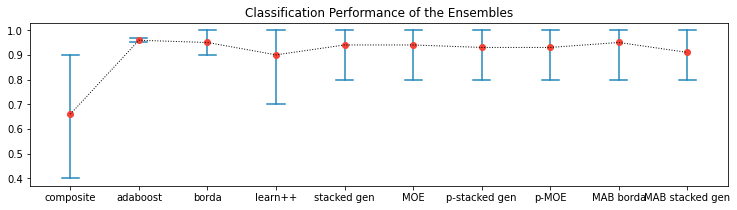

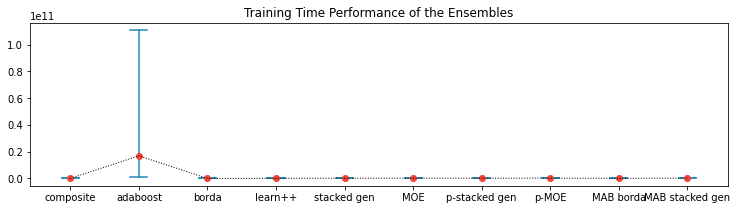

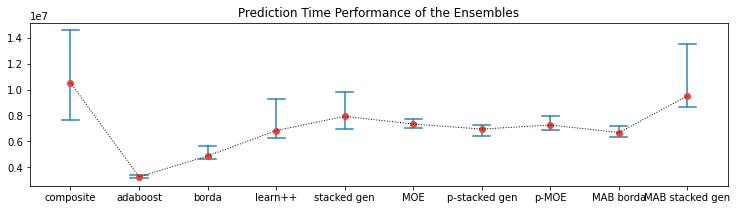

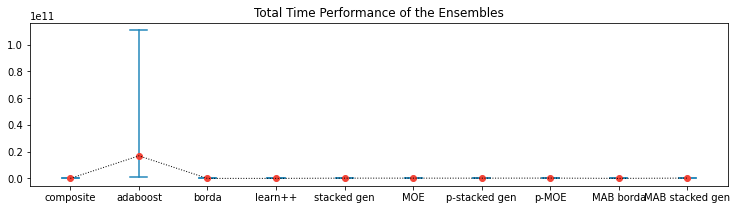

In [40]:
import matplotlib.pyplot as plt
import statistics
from math import sqrt

def calculate_confidence_bound (data):
  temp = sorted(data.copy())
  n = len(temp)
  low = temp[int(0.025*(n+1))]
  # print('low: ',low)
  up = temp[int(0.975*(n+1))-1]
  # print('up: ',up)
  mean = sum(data)/n
  # print('mean: ', mean)
  return (low,up),mean
  
def plot_confidence_interval(x, values, color='#2187bb', horizontal_line_width=0.25):
    # mean = statistics.mean(values)
    # stdev = statistics.stdev(values)
    # confidence_interval = z * stdev / sqrt(len(values))

    (bottom,top),mean = calculate_confidence_bound(values)


    left = x - horizontal_line_width / 2
    # top = mean - confidence_interval
    right = x + horizontal_line_width / 2
    # bottom = mean + confidence_interval
    plt.plot([x, x], [bottom, top], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, mean, 'o', color='#f44336')
    plt.plot()
    # print('x: ',x)
    # print('left: ',left)
    # print('top: ', top)
    # print('bottom: ',bottom)
    # print('right:',right)
    return mean#, confidence_interval


# plt.xticks([1, 2, 3, 4], ['FF', 'BF', 'FFD', 'BFD'])
# plt.title('Confidence Interval')
# # plot_confidence_interval(1, [10, 11, 42, 45, 44])
# # plot_confidence_interval(2, [10, 21, 42, 45, 44])
# # plot_confidence_interval(3, [20, 2, 4, 45, 44])
# # plot_confidence_interval(4, [30, 31, 42, 45, 44])
# plt.show()
mean_list = []
plt.figure(figsize=(12.5,3))
for index,ensemble in enumerate(accuracy_performance):
  mean_list.append(plot_confidence_interval(index,accuracy_performance[ensemble]))
plt.xticks(list(range(len(accuracy_performance.keys()))),accuracy_performance.keys())
plt.plot(mean_list,linewidth = '1',color = 'black',linestyle = 'dotted')
plt.title('Classification Performance of the Ensembles')
plt.show()

mean_list = []
plt.figure(figsize=(12.5,3))
for index,ensemble in enumerate(accuracy_performance):
  mean_list.append(plot_confidence_interval(index,training_time_performance[ensemble]))
plt.xticks(list(range(len(accuracy_performance.keys()))),accuracy_performance.keys())
plt.plot(mean_list,linewidth = '1',color = 'black',linestyle = 'dotted')
plt.title('Training Time Performance of the Ensembles')
plt.show()

mean_list = []
plt.figure(figsize=(12.5,3))
for index,ensemble in enumerate(accuracy_performance):
  mean_list.append(plot_confidence_interval(index,prediction_time_performance[ensemble]))
plt.xticks(list(range(len(accuracy_performance.keys()))),accuracy_performance.keys())
plt.plot(mean_list,linewidth = '1',color = 'black',linestyle = 'dotted')
plt.title('Prediction Time Performance of the Ensembles')
plt.show()

mean_list = []
plt.figure(figsize=(12.5,3))
for index,ensemble in enumerate(accuracy_performance):
  mean_list.append(plot_confidence_interval(index,total_time_performance[ensemble]))
plt.xticks(list(range(len(accuracy_performance.keys()))),accuracy_performance.keys())
plt.plot(mean_list,linewidth = '1',color = 'black',linestyle = 'dotted')
plt.title('Total Time Performance of the Ensembles')
plt.show()

In [43]:
for ensemble in training_time_performance:
  print(ensemble,': ',sum(training_time_performance[ensemble])/(1000000*len(training_time_performance[ensemble])))

composite :  14.7559927
adaboost :  16860.4500457
borda :  11.7607666
learn++ :  12.882457
stacked gen :  191.9442268
MOE :  195.7281858
p-stacked gen :  181.1066083
p-MOE :  232.3849856
MAB borda :  20.1411335
MAB stacked gen :  226.0258385


In [46]:
for ensemble in prediction_time_performance:
  print(ensemble,': ',sum(prediction_time_performance[ensemble])/(1000000*len(prediction_time_performance[ensemble])))

composite :  10.5282355
adaboost :  3.2724309
borda :  4.8773399
learn++ :  6.8391066
stacked gen :  7.9301957
MOE :  7.3446397
p-stacked gen :  6.9515103
p-MOE :  7.2667334
MAB borda :  6.6850607
MAB stacked gen :  9.5004241


In [47]:
for ensemble in total_time_performance:
  print(ensemble,': ',sum(total_time_performance[ensemble])/(1000000*len(total_time_performance[ensemble])))

composite :  25.2842282
adaboost :  16863.7224766
borda :  16.6381065
learn++ :  19.7215636
stacked gen :  199.8744225
MOE :  203.0728255
p-stacked gen :  188.0581186
p-MOE :  239.651719
MAB borda :  26.8261942
MAB stacked gen :  235.5262626
